In [1]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)
import root_pandas,glob

import gc

def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='../images'

import misc_util,correlation_plots

import imp
imp.reload(correlation_plots)

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


<module 'correlation_plots' from '/home/sebouh/sidis_tuples/python/correlation_plots.py'>

In [3]:
sets =  "D_C C D_Fe Fe Pb D_Pb".split()
sets += "MC_D2 MC_C MC_Fe MC_Pb".split()
sets += "no_ecuts_MC_D2 no_ecuts_MC_C no_ecuts_MC_Fe no_ecuts_MC_Pb".split()
sets += "xQ2_MC_D2 xQ2_MC_C xQ2_MC_Fe xQ2_MC_Pb".split()
sets += "no_ecuts_D_C no_ecuts_C no_ecuts_D_Fe no_ecuts_Fe no_ecuts_Pb no_ecuts_D_Pb".split()
sets += "xQ2_D_C xQ2_C xQ2_D_Fe xQ2_Fe xQ2_Pb xQ2_D_Pb".split()

dfs_mixed = {a : root_pandas.read_root("../../eg2/python/mixed_%s.root"%a)  for a in sets}

In [4]:
dfs_data = {a : root_pandas.read_root("/home/seba/CreatePairTuples/Pairs_%s.root" %a.replace("D_",""),a) for a in "D_C C D_Fe Fe Pb D_Pb".split()}


dfs_trigger = {a : root_pandas.read_root("/home/seba/CreatePairTuples/Pairs_%s.root" %a.replace("D_",""),a+"_trigger") for a in "D_C C D_Fe Fe Pb D_Pb".split()}



In [5]:
#now load MC
dfs_data.update({"MC_"+ a : root_pandas.read_root("/home/seba/CreatePairTuples/MC_Pairs_%s.root" %a,a) for a in "Pb D C Fe".split()})




In [6]:
dfs_trigger.update({"MC_"+ a : root_pandas.read_root("/home/seba/CreatePairTuples/MC_Pairs_%s.root" %a,a + "_trigger") for a in "Pb D C Fe".split()})



In [7]:
for dct in dfs_mixed,dfs_data, dfs_trigger:
    dct['D'] = pd.concat([dct['D_'+a] for a in 'C Fe Pb'.split()])

In [8]:
for dct in dfs_mixed,:
    for mixtag in 'xQ2_','no_ecuts_':
        dct[mixtag+'D'] = pd.concat([dct[mixtag+'D_'+a] for a in 'C Fe Pb'.split()])


In [9]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = None
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print (text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)')
    return cutDataframe

def applyCuts(fullDataframe,name='default',isMC=False,isTrigger=True): 
    dataframe = fullDataframe
    if(dataframe.shape[0]>0):
        print ('Entries before cut ', dataframe.shape[0])
    dataframe.eval('inelasticity = nu/5.014', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<4.0', 'Q2>1.0 and Q2<4.0')
    #dataframe = applyCut(dataframe, 'Nu>3.0 and Nu<3.5', '3.0 < Nu < 3.5')
    #dataframe = applyCut(dataframe, 'h_z>0.5', 'h_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p <2.5 ', 'h1_p<2.5 ')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    dataframe = applyCut(dataframe, 'abs(h1_pid)==211', 'h1_pid = pions (trigger)')
    dataframe = applyCut(dataframe, 'nu>2.2 and nu<4.2', 'Nu>2.2 and Nu<4.2')
    dataframe = applyCut(dataframe, 'h1_z <1.0', 'h1_z <1.0')
   
    return dataframe

def applyCutsPair(fullDataframe,name='default',isMC=False,dipion=False,pi_p=False):
    print ('Starting election on dipion variables')
    if (isMC):
        print ('This is MC')
    else: 
        print ('This is Data')
    
    dataframe = fullDataframe
    dataframe.eval('pair_pt = sqrt((h1_p*sin(h1_th)*cos(h1_ph)+h2_p*sin(h2_th)*cos(h2_ph))**2+(h1_p*sin(h1_th)*sin(h1_ph)+h2_p*sin(h2_th)*sin(h2_ph))**2)',inplace=True)
    dataframe.eval('z_tot = h1_z+ h2_z', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe.eval('h2_e = h2_z*nu', inplace=True)
    dataframe.eval('h2_mass = 0.13957*(abs(h2_pid)==211)+.93827208816*(abs(h2_pid)==2212)', inplace=True)
    dataframe.eval('h2_p = sqrt(h2_e*h2_e-h2_mass*h2_mass)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<4.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'nu>3.0 and nu<3.5', '3.0 < nu < 3.5')
    dataframe = applyCut(dataframe, 'h1_z>0.5', 'h1_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p<2.5', 'h1_p<2.5 GeV ')
    dataframe = applyCut(dataframe, 'h2_p<2.5', 'h2_p<2.5 GeV')
    #dataframe = applyCut(dataframe, 'h1_pid*h2_pid<0', 'Opposite sign pairs')
    dataframe.eval('pair_pt2 = pair_pt*pair_pt', inplace=True)
    if dipion:
        dataframe = applyCut(dataframe, 'abs(h2_pid)==211', 'secondary hadrons are pions') 
    if pi_p:
        dataframe = applyCut(dataframe, 'h2_pid==2212', 'secondary hadrons are protons') 
    dataframe = applyCut(dataframe, 'h2_p>0.2', 'h2_p>0.2')
    dataframe = applyCut(dataframe, 'h1_p>0.2', 'h1_p>0.2')
    dataframe = applyCut(dataframe, 'h2_z<1.0', 'h1_z<1.0')
    
    #convert stuff to radians
    if(max(dataframe[:1000].h2_th)>np.pi):
        for f in 'h2_th h1_th h1_ph h2_ph'.split():
            dataframe[f]*=np.pi/180
    ## Theta cuts are not applied in the GiBUU case
    if (not isMC):
        dataframe = applyCut(dataframe, 'h2_th<120*3.14159/180 and h2_th>10*3.14159/180', '10<h2_th<120')
        dataframe = applyCut(dataframe, '(h2_pid==2212) | (h2_pid==211) | (h2_pid==-211 & h2_th>25*3.14159/180 & h2_th<90*3.14159/180) | (h2_pid==-211 & h2_th<40*3.14159/180 & h2_th>25*3.14159/180 & h2_p>0.5)','Theta/P fiducial region selected')
        dataframe = applyCut(dataframe, 'h1_th<120*3.14159/180 and h1_th>10*3.14159/180', '10< h1_th<120')
        dataframe = applyCut(dataframe, '(h1_pid==211) | (h1_pid==-211 & h1_th>25*3.14159/180 & h1_th<90*3.14159/180) | (h1_pid==-211 & h1_th<40*3.14159/180 & h1_th>25*3.14159/180 & h1_p>0.5)','Theta/P fiducial region selected for trigger')
        
    return dataframe



for key in list(dfs_data.keys()):
    if '_2pi' in key or '_pi_p' in key:
        continue
    df = dfs_data[key]
    print(df.columns)
    df.eval('inelasticity = nu/5.014', inplace=True)
    df.eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
    df.eval('pi='+str(np.pi),inplace=True) #not sure why eval doesn't know what pi is.  
    df.eval('diff_phi_cm = 2*pi*(diff_phi_cm<-pi)-2*pi*(diff_phi_cm>pi)')
    df.eval('h1_e = h1_z*nu', inplace=True)
    df.eval('h2_e = h2_z*nu', inplace=True)
    df.eval('h2_mass = 0.13957*(abs(h2_pid)==211)+.93827208816*(abs(h2_pid)==2212)', inplace=True)
    df.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    df.eval('h2_p = sqrt(h2_e*h2_e-h2_mass*h2_mass)', inplace=True)
    df.rename(columns={'drap':'diff_rap_cm'},inplace=True)
    print(df.columns)
    dfs_data[key+"_2pi"] = applyCuts(applyCutsPair(df,dipion=True))
    dfs_data[key+"_pi_p"] = applyCuts(applyCutsPair(df,pi_p=True))
for key in list(dfs_mixed.keys()): 
    if '_2pi' in key or '_pi_p' in key:
        continue
    print('key is ',key)
    dfs_mixed[key+"_2pi"] = applyCuts(applyCutsPair(dfs_mixed[key],dipion=True))
    dfs_mixed[key+"_pi_p"] = applyCuts(applyCutsPair(dfs_mixed[key],pi_p=True))
for key in list(dfs_trigger.keys()):
    if '_2pi' in key or '_pi_p' in key:
        continue
    dfs_trigger[key] = applyCuts(dfs_trigger[key])

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x', 'u',
       'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__'],
      dtype='object')
Index(['dphi', 'dphi_lab', 'diff_rap_cm', 'h1_z', 'h2_z', 'h1_cm_pt',
       'h2_cm_pt', 'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid',
       'h2_pid', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass',
       'pair_pt', 'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x',
       'u', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__', 'inelasticity',
       'diff_phi_cm', 'pi', 'h1_e', 'h2_e', 'h2_mass', 'h1_p', 'h2_p'],
      dtype='object')
Starting election on dipion variables
This is Data
Q2>1.0 : 932821  (100.00  %)
h1_z>0.5 : 530131  (56.83  %)
h1_p<2.5 GeV  454397  (85.71  %)
h2_p<

Nu>2.2 and Nu<4.2 38334  (98.81  %)
h1_z <1.0 38334  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 1865381  (100.00  %)
h1_z>0.5 : 734962  (39.40  %)
h1_p<2.5 GeV  656707  (89.35  %)
h2_p<2.5 GeV 656429  (99.96  %)
secondary hadrons are protons 270936  (41.27  %)
h2_p>0.2 270936  (100.00  %)
h1_p>0.2 270936  (100.00  %)
h1_z<1.0 270917  (99.99  %)
10<h2_th<120 270917  (100.00  %)
Theta/P fiducial region selected 270917  (100.00  %)
10< h1_th<120 270917  (100.00  %)
Theta/P fiducial region selected for trigger 53099  (19.60  %)
Entries before cut  53099
Q2>1.0 and Q2<4.0 53099  (100.00  %)
h1_p<2.5  53099  (100.00  %)
inelasticity < 0.85 53099  (100.00  %)
h1_pid = pions (trigger) 53099  (100.00  %)
Nu>2.2 and Nu<4.2 52521  (98.91  %)
h1_z <1.0 52521  (100.00  %)
Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th',

Q2>1.0 : 2196429  (100.00  %)
h1_z>0.5 : 1350443  (61.48  %)
h1_p<2.5 GeV  1033362  (76.52  %)
h2_p<2.5 GeV 1030935  (99.77  %)
secondary hadrons are pions 840592  (81.54  %)
h2_p>0.2 840592  (100.00  %)
h1_p>0.2 840592  (100.00  %)
h1_z<1.0 840592  (100.00  %)
10<h2_th<120 840592  (100.00  %)
Theta/P fiducial region selected 840592  (100.00  %)
10< h1_th<120 840592  (100.00  %)
Theta/P fiducial region selected for trigger 150658  (17.92  %)
Entries before cut  150658
Q2>1.0 and Q2<4.0 150658  (100.00  %)
h1_p<2.5  150658  (100.00  %)
inelasticity < 0.85 150658  (100.00  %)
h1_pid = pions (trigger) 150658  (100.00  %)
Nu>2.2 and Nu<4.2 148213  (98.38  %)
h1_z <1.0 148213  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 2196429  (100.00  %)
h1_z>0.5 : 1350443  (61.48  %)
h1_p<2.5 GeV  1033362  (76.52  %)
h2_p<2.5 GeV 1030935  (99.77  %)
secondary hadrons are protons 190343  (18.46  %)
h2_p>0.2 190343  (100.00  %)
h1_p>0.2 190343  (100.00  %)
h1_z<1.0 190341  (100

Nu>2.2 and Nu<4.2 180707  (99.21  %)
h1_z <1.0 180707  (100.00  %)
key is  D_C
Starting election on dipion variables
This is Data
Q2>1.0 : 3054408  (100.00  %)
h1_z>0.5 : 1753669  (57.41  %)
h1_p<2.5 GeV  1451860  (82.79  %)
h2_p<2.5 GeV 1451860  (100.00  %)
secondary hadrons are pions 999020  (68.81  %)
h2_p>0.2 999020  (100.00  %)
h1_p>0.2 999020  (100.00  %)
h1_z<1.0 999020  (100.00  %)
10<h2_th<120 999020  (100.00  %)
Theta/P fiducial region selected 999020  (100.00  %)
10< h1_th<120 999020  (100.00  %)
Theta/P fiducial region selected for trigger 999020  (100.00  %)
Entries before cut  999020
Q2>1.0 and Q2<4.0 999020  (100.00  %)
h1_p<2.5  999020  (100.00  %)
inelasticity < 0.85 999020  (100.00  %)
h1_pid = pions (trigger) 999020  (100.00  %)
Nu>2.2 and Nu<4.2 992028  (99.30  %)
h1_z <1.0 991986  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 3054408  (100.00  %)
h1_z>0.5 : 1753669  (57.41  %)
h1_p<2.5 GeV  1451860  (82.79  %)
h2_p<2.5 GeV 1451860  (100.00

inelasticity < 0.85 1348732  (100.00  %)
h1_pid = pions (trigger) 1348732  (100.00  %)
Nu>2.2 and Nu<4.2 1339130  (99.29  %)
h1_z <1.0 1339065  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 4109244  (100.00  %)
h1_z>0.5 : 2367021  (57.60  %)
h1_p<2.5 GeV  1958800  (82.75  %)
h2_p<2.5 GeV 1958800  (100.00  %)
secondary hadrons are protons 610068  (31.14  %)
h2_p>0.2 610068  (100.00  %)
h1_p>0.2 610068  (100.00  %)
h1_z<1.0 610068  (100.00  %)
10<h2_th<120 610068  (100.00  %)
Theta/P fiducial region selected 610068  (100.00  %)
10< h1_th<120 610068  (100.00  %)
Theta/P fiducial region selected for trigger 610068  (100.00  %)
Entries before cut  610068
Q2>1.0 and Q2<4.0 610068  (100.00  %)
h1_p<2.5  610068  (100.00  %)
inelasticity < 0.85 610068  (100.00  %)
h1_pid = pions (trigger) 610068  (100.00  %)
Nu>2.2 and Nu<4.2 604691  (99.12  %)
h1_z <1.0 604656  (99.99  %)
key is  MC_D2
Starting election on dipion variables
This is Data
Q2>1.0 : 2718815  (100.00  %)
h1

h1_p<2.5  414442  (100.00  %)
inelasticity < 0.85 414442  (100.00  %)
h1_pid = pions (trigger) 414442  (100.00  %)
Nu>2.2 and Nu<4.2 411006  (99.17  %)
h1_z <1.0 411000  (100.00  %)
key is  no_ecuts_MC_C
Starting election on dipion variables
This is Data
Q2>1.0 : 2709020  (100.00  %)
h1_z>0.5 : 2013570  (74.33  %)
h1_p<2.5 GeV  1286320  (63.88  %)
h2_p<2.5 GeV 1286320  (100.00  %)
secondary hadrons are pions 875758  (68.08  %)
h2_p>0.2 875758  (100.00  %)
h1_p>0.2 875758  (100.00  %)
h1_z<1.0 875758  (100.00  %)
10<h2_th<120 875758  (100.00  %)
Theta/P fiducial region selected 875758  (100.00  %)
10< h1_th<120 875758  (100.00  %)
Theta/P fiducial region selected for trigger 875758  (100.00  %)
Entries before cut  875758
Q2>1.0 and Q2<4.0 875758  (100.00  %)
h1_p<2.5  875758  (100.00  %)
inelasticity < 0.85 875758  (100.00  %)
h1_pid = pions (trigger) 875758  (100.00  %)
Nu>2.2 and Nu<4.2 869270  (99.26  %)
h1_z <1.0 869249  (100.00  %)
Starting election on dipion variables
This is Data

Q2>1.0 and Q2<4.0 854608  (100.00  %)
h1_p<2.5  854608  (100.00  %)
inelasticity < 0.85 854608  (100.00  %)
h1_pid = pions (trigger) 854608  (100.00  %)
Nu>2.2 and Nu<4.2 847926  (99.22  %)
h1_z <1.0 847919  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 2668956  (100.00  %)
h1_z>0.5 : 1981518  (74.24  %)
h1_p<2.5 GeV  1269122  (64.05  %)
h2_p<2.5 GeV 1269122  (100.00  %)
secondary hadrons are protons 414514  (32.66  %)
h2_p>0.2 414514  (100.00  %)
h1_p>0.2 414514  (100.00  %)
h1_z<1.0 414514  (100.00  %)
10<h2_th<120 414514  (100.00  %)
Theta/P fiducial region selected 414514  (100.00  %)
10< h1_th<120 414514  (100.00  %)
Theta/P fiducial region selected for trigger 414514  (100.00  %)
Entries before cut  414514
Q2>1.0 and Q2<4.0 414514  (100.00  %)
h1_p<2.5  414514  (100.00  %)
inelasticity < 0.85 414514  (100.00  %)
h1_pid = pions (trigger) 414514  (100.00  %)
Nu>2.2 and Nu<4.2 411336  (99.23  %)
h1_z <1.0 411333  (100.00  %)
key is  xQ2_MC_Pb
Starting elect

h1_p<2.5  422118  (100.00  %)
inelasticity < 0.85 422118  (100.00  %)
h1_pid = pions (trigger) 422118  (100.00  %)
Nu>2.2 and Nu<4.2 418692  (99.19  %)
h1_z <1.0 418670  (99.99  %)
key is  no_ecuts_Pb
Starting election on dipion variables
This is Data
Q2>1.0 : 859370  (100.00  %)
h1_z>0.5 : 472110  (54.94  %)
h1_p<2.5 GeV  399340  (84.59  %)
h2_p<2.5 GeV 399340  (100.00  %)
secondary hadrons are pions 166390  (41.67  %)
h2_p>0.2 166390  (100.00  %)
h1_p>0.2 166390  (100.00  %)
h1_z<1.0 166390  (100.00  %)
10<h2_th<120 166390  (100.00  %)
Theta/P fiducial region selected 166390  (100.00  %)
10< h1_th<120 166390  (100.00  %)
Theta/P fiducial region selected for trigger 166390  (100.00  %)
Entries before cut  166390
Q2>1.0 and Q2<4.0 166390  (100.00  %)
h1_p<2.5  166390  (100.00  %)
inelasticity < 0.85 166390  (100.00  %)
h1_pid = pions (trigger) 166390  (100.00  %)
Nu>2.2 and Nu<4.2 164917  (99.11  %)
h1_z <1.0 164917  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0

h1_p<2.5  415219  (100.00  %)
inelasticity < 0.85 415219  (100.00  %)
h1_pid = pions (trigger) 415219  (100.00  %)
Nu>2.2 and Nu<4.2 411939  (99.21  %)
h1_z <1.0 411921  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 1805333  (100.00  %)
h1_z>0.5 : 997048  (55.23  %)
h1_p<2.5 GeV  843522  (84.60  %)
h2_p<2.5 GeV 843522  (100.00  %)
secondary hadrons are protons 428303  (50.78  %)
h2_p>0.2 428303  (100.00  %)
h1_p>0.2 428303  (100.00  %)
h1_z<1.0 428303  (100.00  %)
10<h2_th<120 428303  (100.00  %)
Theta/P fiducial region selected 428303  (100.00  %)
10< h1_th<120 428303  (100.00  %)
Theta/P fiducial region selected for trigger 428303  (100.00  %)
Entries before cut  428303
Q2>1.0 and Q2<4.0 428303  (100.00  %)
h1_p<2.5  428303  (100.00  %)
inelasticity < 0.85 428303  (100.00  %)
h1_pid = pions (trigger) 428303  (100.00  %)
Nu>2.2 and Nu<4.2 424853  (99.19  %)
h1_z <1.0 424831  (99.99  %)
key is  xQ2_Pb
Starting election on dipion variables
This is Data
Q2>1.0 :

10< h1_th<120 1531627  (100.00  %)
Theta/P fiducial region selected for trigger 1531627  (100.00  %)
Entries before cut  1531627
Q2>1.0 and Q2<4.0 1531627  (100.00  %)
h1_p<2.5  1531627  (100.00  %)
inelasticity < 0.85 1531627  (100.00  %)
h1_pid = pions (trigger) 1531627  (100.00  %)
Nu>2.2 and Nu<4.2 1519301  (99.20  %)
h1_z <1.0 1519231  (100.00  %)
Entries before cut  2294598
Q2>1.0 and Q2<4.0 2294597  (100.00  %)
h1_p<2.5  2074782  (90.42  %)
inelasticity < 0.85 2074782  (100.00  %)
h1_pid = pions (trigger) 646069  (31.14  %)
Nu>2.2 and Nu<4.2 638222  (98.79  %)
h1_z <1.0 638207  (100.00  %)
Entries before cut  2087382
Q2>1.0 and Q2<4.0 2087382  (100.00  %)
h1_p<2.5  1908242  (91.42  %)
inelasticity < 0.85 1908242  (100.00  %)
h1_pid = pions (trigger) 479645  (25.14  %)
Nu>2.2 and Nu<4.2 473386  (98.70  %)
h1_z <1.0 473378  (100.00  %)
Entries before cut  3394111
Q2>1.0 and Q2<4.0 3394111  (100.00  %)
h1_p<2.5  3067888  (90.39  %)
inelasticity < 0.85 3067888  (100.00  %)
h1_pid = 

In [66]:
def mix_summary_plots(prefix='',suffix='_2pi', queries=['h1_z == h1_z'], labels=None,useInFit=True, xvar='abs(diff_phi_lab)',
                      bins=10,xmin=0, xmax=np.pi,xlbl='$\\Delta\\phi_{\\mathrm{lab}}$',
                      suptitle=None,fitParams=None, showBand = True):
    rows = len(queries)
     
    # two columns: first is the num and denom (mixed A and mixed D)
    # second is M_A/M_D
    fig,axs = plt.subplots(rows,2, sharey='col',sharex='all', figsize=(14,3.5*rows))
    if rows == 1:
        axs = [axs]
    fig.subplots_adjust(hspace=0)
    if suptitle:
        fig.suptitle(suptitle)
    targets = 'D C Fe Pb'.split()
    nuclei = 'C Fe Pb'.split()
    colors = {'D':'k', 'C':'tab:blue', 'Fe':'tab:orange','Pb':'tab:green'}
    
    # calculate the  weighted mean uncertainty
    sumNum = 0
    sumNumCos2dphi = 0
    sumDenom = 0
    sumDenomCos2dphi = 0
    
    for j in range(len(queries)):
        
        ym = {}
        dym = {}
        for a in targets + 'D_C D_Fe D_Pb'.split():
            df = dfs_mixed[prefix+a+suffix].query(queries[j])
            ym[a],x = np.histogram(df.eval(xvar),bins=bins,range=(xmin,xmax))
            x = np.add(x[:-1],x[1:])/2
            denom = np.mean(ym[a])
            dym[a] = np.sqrt(ym[a])/denom
            ym[a] = ym[a]/denom
            del df
        
        
        
        plt.sca(axs[j][0])
        plt.gca().axhline(1,color='0.7',linestyle='--')
        
        plt.gca().set_ylabel('$M$')
        for a in targets:
            plt.errorbar(x,ym[a],dym[a],linestyle='',color=colors[a],marker='o',markersize=5,label=a)
            
        plt.sca(axs[j][1])
        plt.gca().set_ylabel('$M_A/M_D$')
        plt.gca().axhline(1,color='0.7',linestyle='--')
        for a in nuclei:
            yr = ym[a]/ym['D_' + a]
            dyr = ym[a]/ym['D_' + a]*np.hypot(dym['D_' + a]/ym['D_' + a], dym[a]/ym[a])
            plt.errorbar(x,yr,dyr,linestyle='',color=colors[a],marker='o',markersize=5,label=a)
            if useInFit is True or useInFit[j] == True:
                sumNum += sum((yr-1)**2/dyr**2)
                sumNumCos2dphi += sum(np.cos(2*x)*(yr-1)**2/dyr**2)
                sumDenom += sum(1/dyr**2)
                sumDenomCos2dphi += sum(np.cos(2*x)**2/dyr**2)
        if not labels is None:
            axs[j][0].text(0.5,0.9, labels[j],transform = axs[j][0].transAxes,fontsize='large')
            axs[j][1].text(0.5,0.9, labels[j],transform = axs[j][1].transAxes,fontsize='large')
        axs[j][0].set_xlim(xmin,xmax)
        axs[j][1].set_xlim(xmin,xmax)
    for i in range(2):
        axs[-1][i].set_xlabel(xlbl)
    
    axs[0][0].legend()
    C0,C2 = 0,0
    if showBand:
        if fitParams == None:
            #C0 = sumNum/sumDenom
            #C2 = sumNumCos2dphi/sumDenom#Cos2dphi
            C0 = np.sqrt(sumNum/sumDenom)
            C2 = abs(sumNumCos2dphi)/sumNumCos2dphi*np.sqrt(abs(sumNumCos2dphi)/sumDenomCos2dphi)
        else :
            C0,C2 = fitParams
        print("estimated uncertainty=",C0,"+",C2,"*cos(2*dphi)")
        if 'abs(diff_phi' in xvar:
            x1 = np.linspace(0,np.pi, 100)
            #y1 = 1+np.sqrt(C0+np.cos(2*x1)*C2)
            y1 = 1+(C0+np.cos(2*x1)*C2)
            x2 = np.linspace(np.pi,0, 100)
            #y2 = 1-np.sqrt(C0+np.cos(2*x2)*C2)
            y2 = 1-(C0+np.cos(2*x2)*C2)
            for j in range(len(queries)):
                axs[j][1].fill(list(x1)+list(x2), list(y1)+list(y2),alpha=0.3,color='0.5')
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    return C0,C2

In [75]:
split_by_trigger=dict(queries=['h1_pid==211','h1_pid==-211'], labels=['$\\pi^+\\pi$','$\\pi^-\\pi$'])
partitions = [.1,.2,.3,.4,.5]
slices = [(partitions[i],partitions[i+1]) for i in range(len(partitions)-1)]
split_by_z=dict(queries=['h2_z==h2_z']+\
                      [f'h2_z>{mn} and h2_z<{mx}' for mn,mx in slices], 
                      labels=['all $0.1<z_2<0.5$'] + [f'${mn}< z_2<{mx}$' for mn,mx in slices], useInFit=[False]+[True]*len(slices))

partitions = [5, 30, 55, 70, 100]
slices = [(partitions[i],partitions[i+1]) for i in range(len(partitions)-1)]
split_by_th2=dict(queries=['h2_z==h2_z']+\
                      [f'h2_th*180/3.141592>{mn} and h2_th*180/3.141592<{mx}' for mn,mx in slices], 
                      labels=['all $\\theta_{h2}$'] + [f'${mn}< \\theta_{{h2}}<{mx}$' for mn,mx in slices], useInFit=[False]+[True]*len(slices))

#identifier for datasets
normal_mixing = dict(prefix='',suffix='_2pi')
xQ2_mixing = dict(prefix='xQ2_',suffix='_2pi')
nocuts_mixing = dict(prefix='no_ecuts_',suffix='_2pi')

cm = dict(xvar='abs(diff_phi_cm)',bins=10,xmin=0, xmax=np.pi,
                  xlbl='$|\\Delta\\phi_{\\mathrm{cm}}|$')
lab = dict(xvar='abs(diff_phi_lab)',bins=20,xmin=0, xmax=np.pi,
                  xlbl='|$\\Delta\\phi_{\\mathrm{lab}}|$')

estimated uncertainty= 0.017038355354390727 + 0.006035124569201342 *cos(2*dphi)
estimated uncertainty= 0.017038355354390727 + 0 *cos(2*dphi)


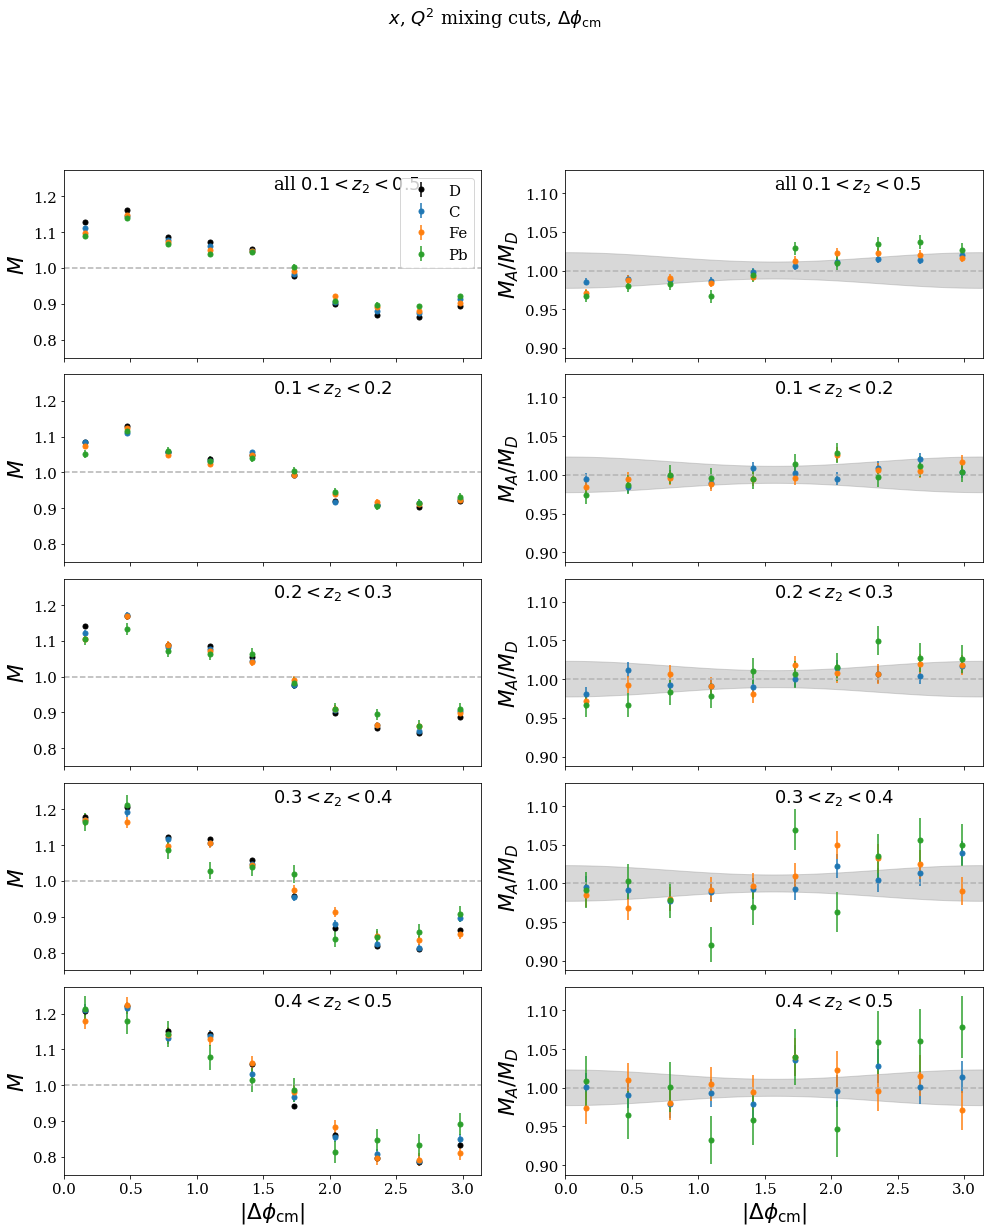

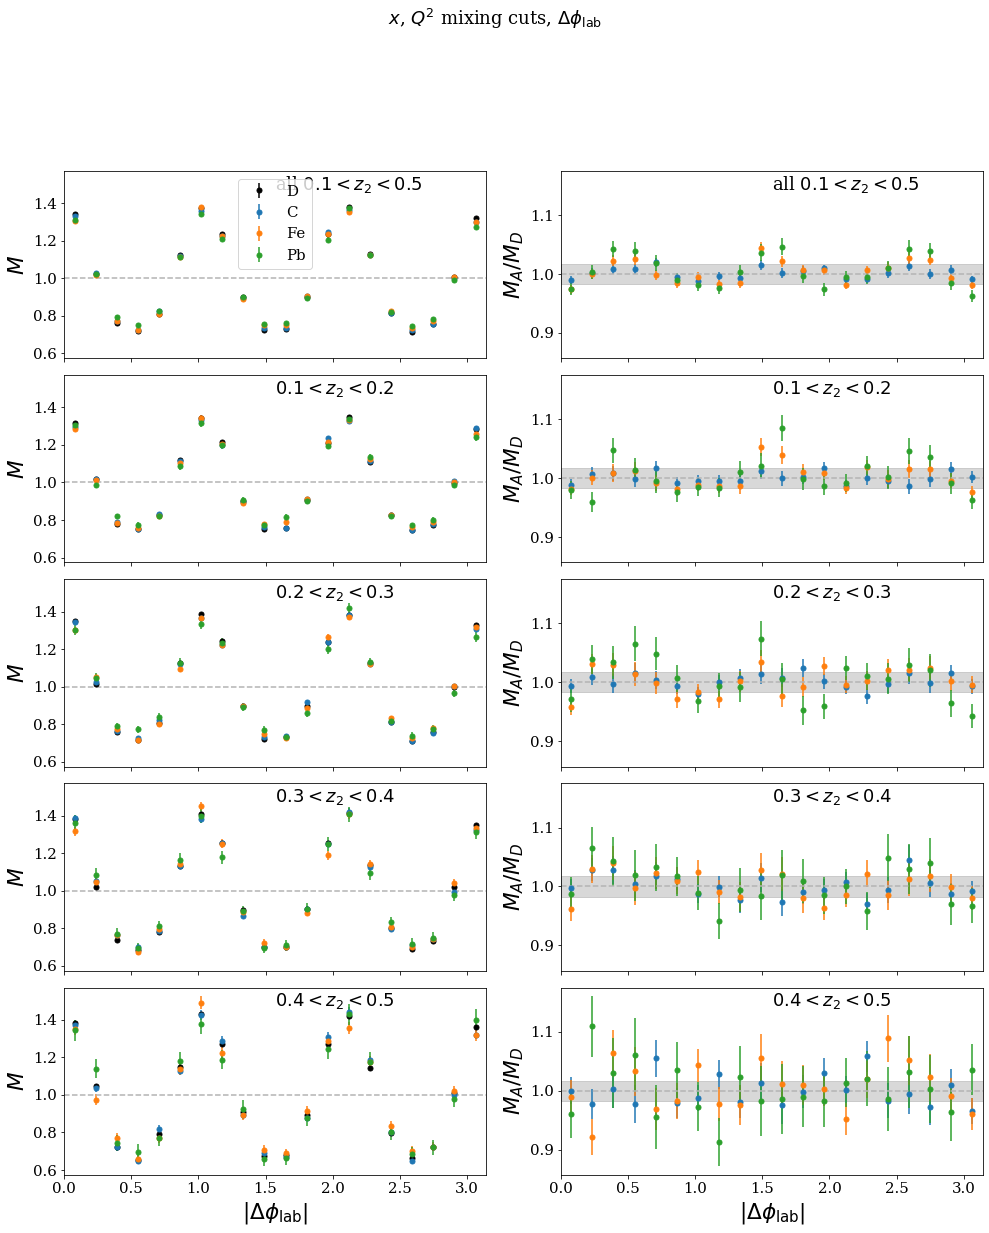

In [76]:


#mix_summary_plots(**normal_mixing, **split_by_z, **lab, suptitle='$x$, $\\Delta\\Phi_q$ mixing cuts, $\\Delta\\phi_{\\mathrm{lab}}$')
#plt.savefig("../images/mixtest_normal_z2_lab.png",bbox_inches='tight')
#mix_summary_plots(**normal_mixing, **split_by_z, **cm, suptitle='$x$,$\\Delta\\Phi_q$ mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$')
#plt.savefig("../images/mixtest_normal_z2_cm.png",bbox_inches='tight')
C0,C1 = mix_summary_plots(**xQ2_mixing, **split_by_z, **cm, suptitle='$x$, $Q^2$ mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$')
plt.savefig("../images/mixtest_xQ2_z2_cm.png",bbox_inches='tight')
mix_summary_plots(**xQ2_mixing, **split_by_z, **lab, suptitle='$x$, $Q^2$ mixing cuts, $\\Delta\\phi_{\\mathrm{lab}}$',fitParams=(C0,0))
plt.savefig("../images/mixtest_xQ2_z2_lab.png",bbox_inches='tight')
#mix_summary_plots(**nocuts_mixing, **split_by_z, **lab, suptitle='no mixing cuts, $\\Delta\\phi_{\\mathrm{lab}}$')
#plt.savefig("../images/mixtest_no_ecuts_z2_lab.png",bbox_inches='tight')
#mix_summary_plots(**nocuts_mixing, **split_by_z, **cm, suptitle='no mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$')
#plt.savefig("../images/mixtest_no_ecuts_z2_cm.png",bbox_inches='tight')

estimated uncertainty= 0.017038355354390727 + 0.006035124569201342 *cos(2*dphi)
estimated uncertainty= 0.017038355354390727 + 0 *cos(2*dphi)


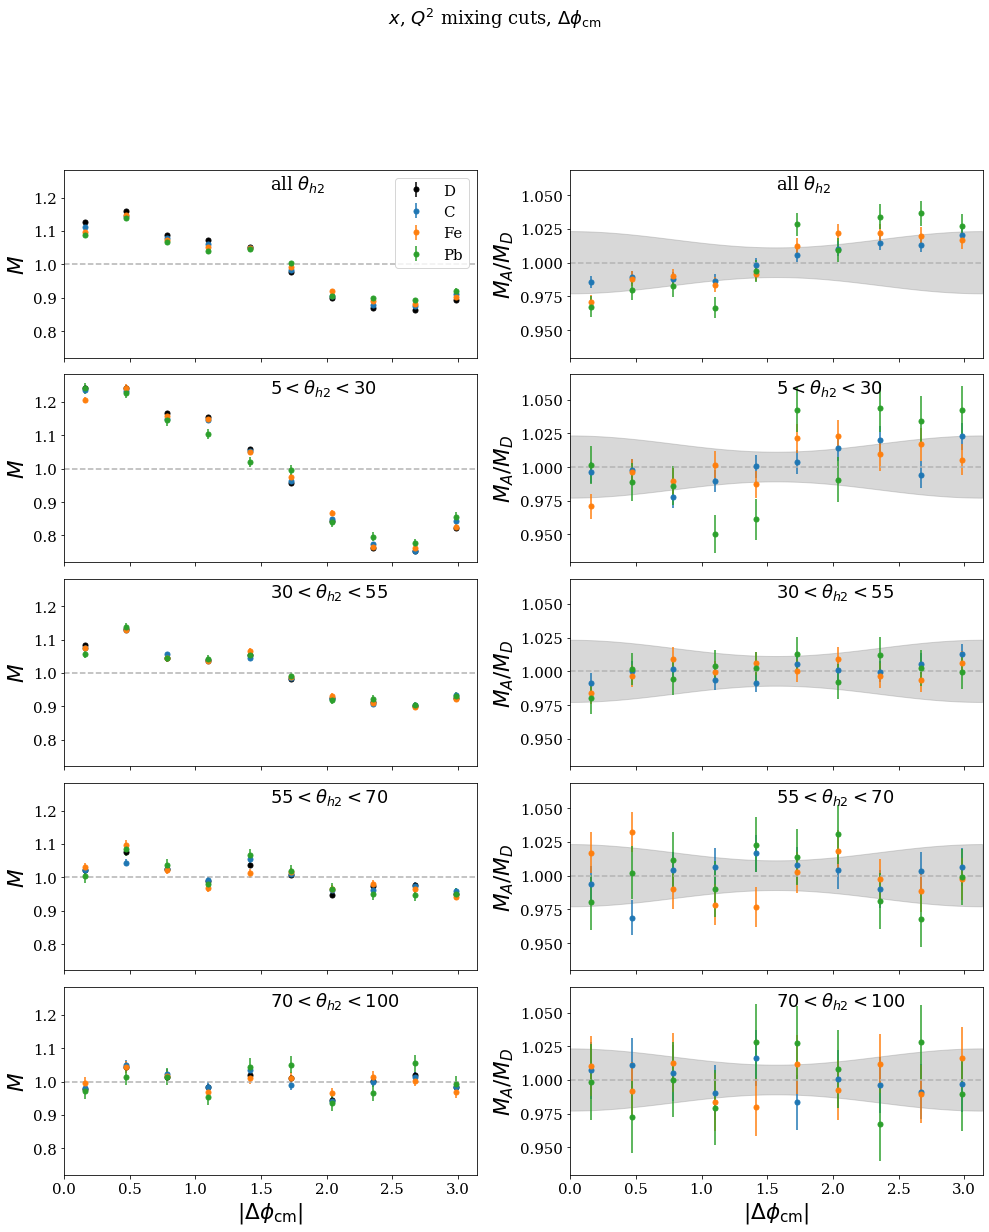

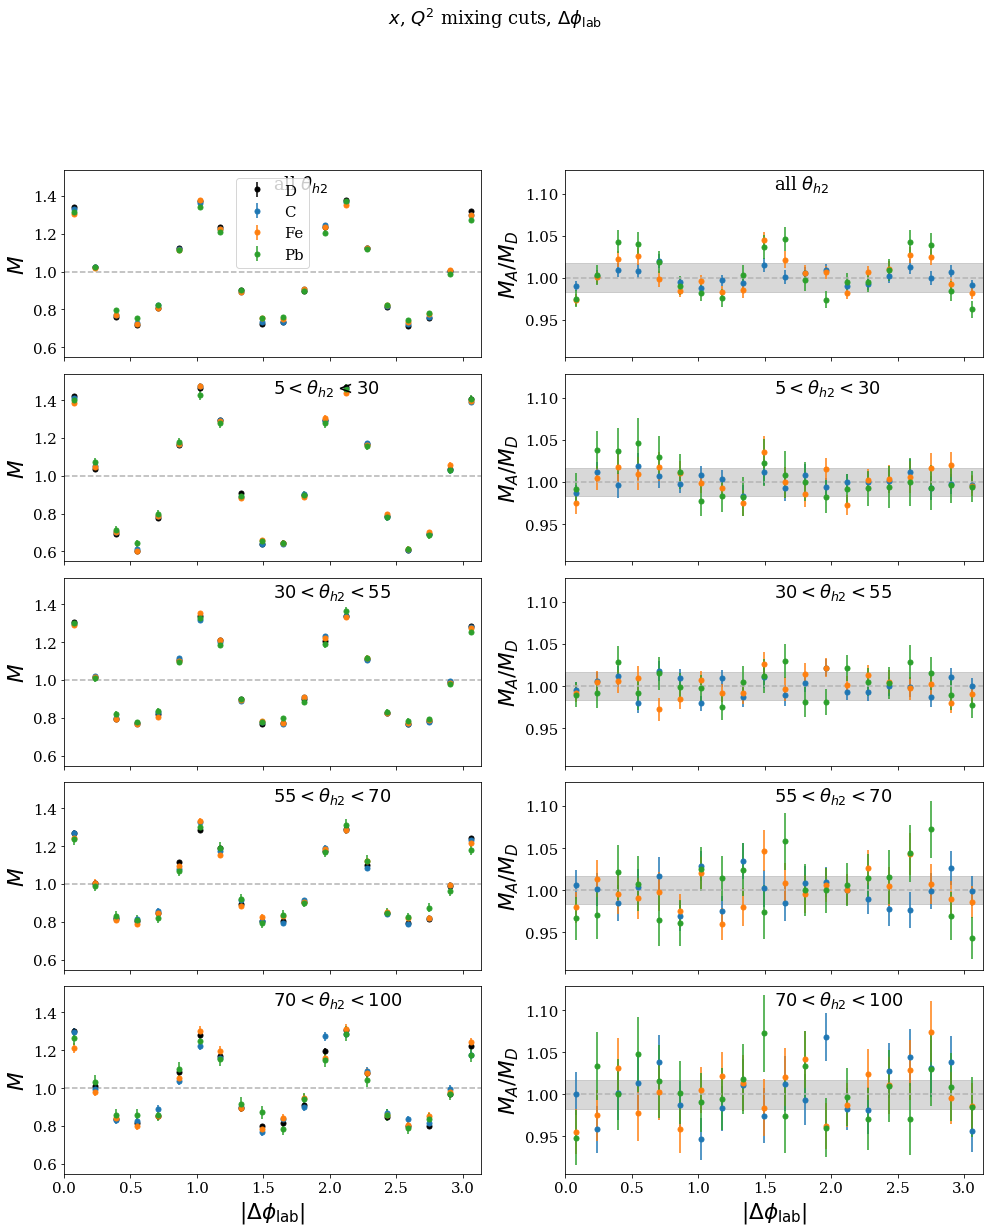

In [77]:


#mix_summary_plots(**normal_mixing, **split_by_th2, **lab, suptitle='$x$, $\\Delta\\Phi_q$ mixing cuts, $\\Delta\\phi_{\\mathrm{lab}}$')
#plt.savefig("../images/mixtest_normal_theta_h2_lab.png",bbox_inches='tight')
#mix_summary_plots(**normal_mixing, **split_by_th2, **cm, suptitle='$x$,$\\Delta\\Phi_q$ mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$')
#plt.savefig("../images/mixtest_normal_theta_h2_cm.png",bbox_inches='tight')
mix_summary_plots(**xQ2_mixing, **split_by_th2, **cm, suptitle='$x$, $Q^2$ mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$',fitParams=(C0,C1))
plt.savefig("../images/mixtest_xQ2_theta_h2_cm.png",bbox_inches='tight')
mix_summary_plots(**xQ2_mixing, **split_by_th2, **lab, suptitle='$x$, $Q^2$ mixing cuts, $\\Delta\\phi_{\\mathrm{lab}}$',fitParams=(C0,0))
plt.savefig("../images/mixtest_xQ2_theta_h2_lab.png",bbox_inches='tight')
#mix_summary_plots(**nocuts_mixing, **split_by_th2, **lab, suptitle='no mixing cuts, $\\Delta\\phi_{\\mathrm{lab}}$')
#plt.savefig("../images/mixtest_no_ecuts_theta_h2_lab.png",bbox_inches='tight')
#mix_summary_plots(**nocuts_mixing, **split_by_th2, **cm, suptitle='no mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$')
#plt.savefig("../images/mixtest_no_ecuts_theta_h2_cm.png",bbox_inches='tight')

estimated uncertainty= 0.017038355354390727 + 0.006035124569201342 *cos(2*dphi)
estimated uncertainty= 0.017038355354390727 + 0 *cos(2*dphi)


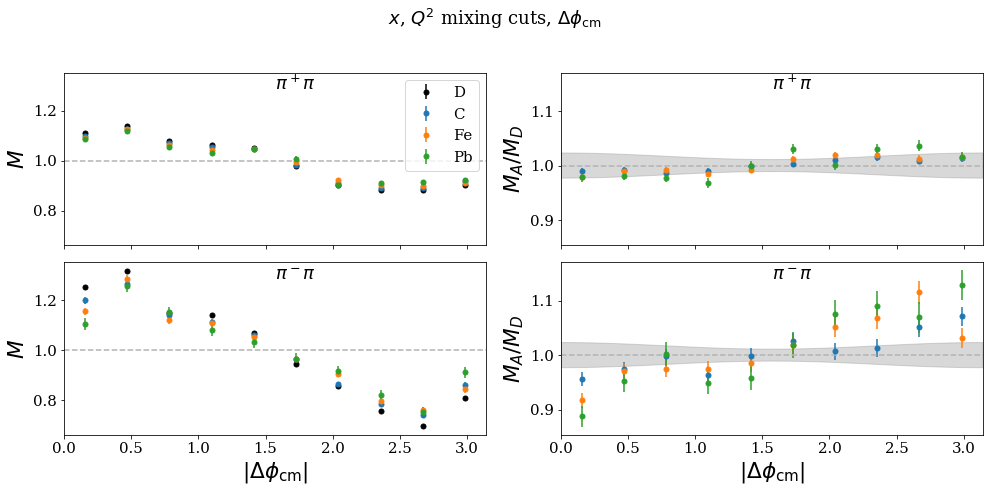

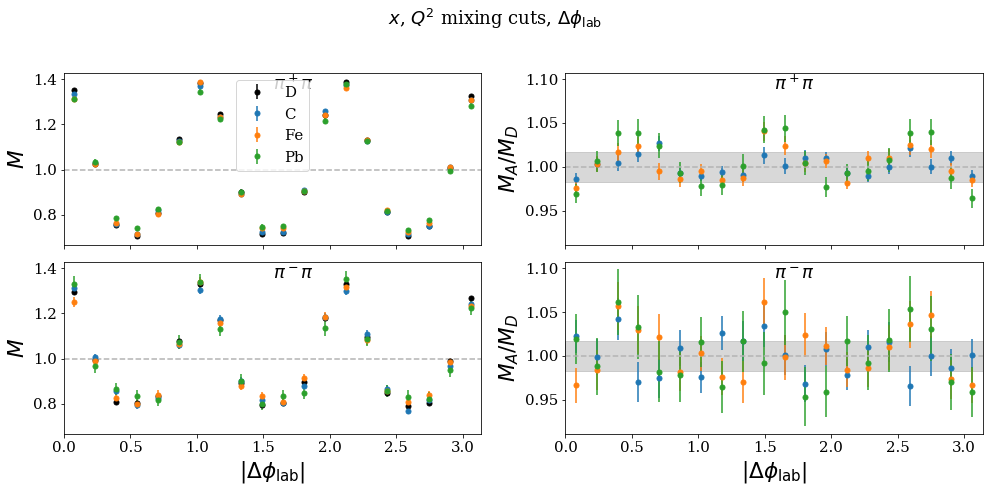

In [78]:
#mix_summary_plots(**normal_mixing, **split_by_trigger, **lab, suptitle='$x$, $\\Delta\\Phi_q$ mixing cuts, $\\Delta\\phi_{\\mathrm{lab}}$')
#plt.savefig("../images/mixtest_normal_trigger_lab.png",bbox_inches='tight')
#mix_summary_plots(**normal_mixing, **split_by_trigger, **cm, suptitle='$x$,$\\Delta\\Phi_q$ mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$')
#plt.savefig("../images/mixtest_normal_trigger_cm.png",bbox_inches='tight')
mix_summary_plots(**xQ2_mixing, **split_by_trigger, **cm, suptitle='$x$, $Q^2$ mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$',fitParams=(C0,C1))
plt.savefig("../images/mixtest_xQ2_trigger_cm.png",bbox_inches='tight')
mix_summary_plots(**xQ2_mixing, **split_by_trigger, **lab, suptitle='$x$, $Q^2$ mixing cuts, $\\Delta\\phi_{\\mathrm{lab}}$',fitParams=(C0,0))
plt.savefig("../images/mixtest_xQ2_trigger_lab.png",bbox_inches='tight')
#mix_summary_plots(**nocuts_mixing, **split_by_trigger, **lab, suptitle='no mixing cuts, $\\Delta\\phi_{\\mathrm{lab}}$')
#plt.savefig("../images/mixtest_no_ecuts_trigger_lab.png",bbox_inches='tight')
#mix_summary_plots(**nocuts_mixing, **split_by_trigger, **cm, suptitle='no mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$')
#plt.savefig("../images/mixtest_no_ecuts_trigger_cm.png",bbox_inches='tight')

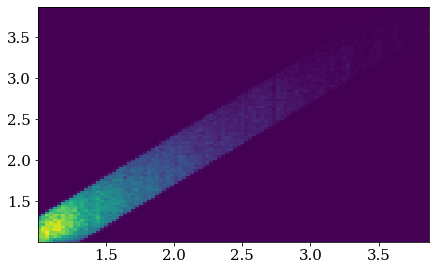

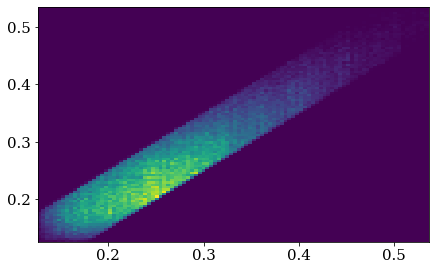

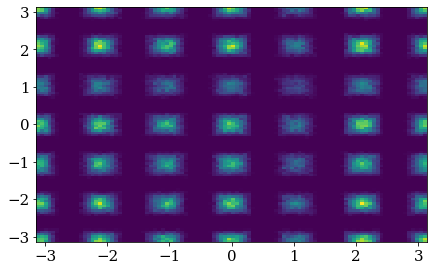

In [15]:
plt.hist2d(dfs_mixed['xQ2_C'].Q2,dfs_mixed['xQ2_C'].mixevt_Q2,bins=100)
plt.show()
plt.hist2d(dfs_mixed['xQ2_C'].x,dfs_mixed['xQ2_C'].mixevt_x,bins=100)
plt.show()
plt.hist2d(dfs_mixed['xQ2_C'].e_ph,dfs_mixed['xQ2_C'].mixevt_e_ph,bins=100)
plt.show()

(array([[1.6350e+03, 3.2140e+03, 3.3300e+03, 2.7720e+03, 1.8370e+03,
         1.1830e+03, 6.3000e+02, 3.3900e+02, 1.3600e+02, 2.4000e+01],
        [4.2220e+03, 8.7510e+03, 9.1160e+03, 7.3700e+03, 5.0320e+03,
         3.0540e+03, 1.7070e+03, 9.0400e+02, 3.4100e+02, 6.3000e+01],
        [5.4660e+03, 1.0833e+04, 1.1275e+04, 9.1370e+03, 6.3360e+03,
         3.8350e+03, 2.0940e+03, 9.9700e+02, 4.1000e+02, 8.7000e+01],
        [4.9420e+03, 9.8660e+03, 1.0069e+04, 8.4990e+03, 5.6640e+03,
         3.5310e+03, 1.8950e+03, 9.6400e+02, 4.0400e+02, 8.6000e+01],
        [3.6320e+03, 7.3310e+03, 7.2700e+03, 5.9250e+03, 4.0860e+03,
         2.5400e+03, 1.4280e+03, 6.7600e+02, 2.6100e+02, 7.1000e+01],
        [2.1560e+03, 4.0750e+03, 4.3280e+03, 3.5570e+03, 2.4270e+03,
         1.4620e+03, 8.5900e+02, 3.9400e+02, 1.5200e+02, 4.0000e+01],
        [1.2050e+03, 2.4670e+03, 2.5680e+03, 2.1920e+03, 1.4020e+03,
         8.9900e+02, 4.9000e+02, 2.3000e+02, 1.0200e+02, 2.5000e+01],
        [5.8500e+02, 1.1980

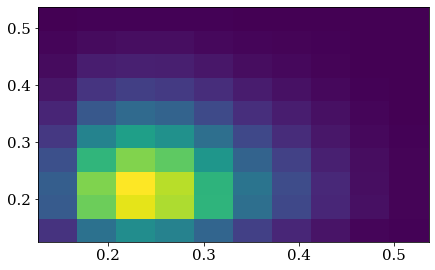

In [133]:
df = dfs_mixed['no_ecuts_C']
plt.hist2d(df.x,df.mixevt_x)

In [101]:
max(dfs_mixed['xQ2_C'].Q2-dfs_mixed['xQ2_C'].mixevt_Q2)

0.2999992370605469

In [102]:
max(dfs_mixed['xQ2_C'].x-dfs_mixed['xQ2_C'].mixevt_x)

0.04999999701976776

In [103]:
max(dfs_mixed['C'].x-dfs_mixed['C'].mixevt_x)

0.049999967217445374

(array([      0.,       0.,       0.,       0., 1126417., 1135512.,
              0.,       0.,       0.,       0.]),
 array([-9. , -7.2, -5.4, -3.6, -1.8,  0. ,  1.8,  3.6,  5.4,  7.2,  9. ]),
 <a list of 10 Patch objects>)

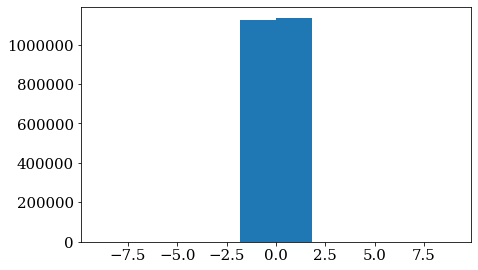

In [108]:
plt.hist((dfs_mixed['C'].e_ph-dfs_mixed['C'].mixevt_e_ph)*np.sin(dfs_mixed['C'].mixevt_e_th)**180/np.pi,range=(-9,9))

In [13]:
#now for MC
for k in list(dfs_mixed.keys()):
    if 'D2' in k:
        dfs_mixed[k.replace('D2','D')]=dfs_mixed[k]
        dfs_mixed[k.replace('D2','D_C')]=dfs_mixed[k]
        dfs_mixed[k.replace('D2','D_Fe')]=dfs_mixed[k]
        dfs_mixed[k.replace('D2','D_Pb')]=dfs_mixed[k]

estimated uncertainty= 0.004033554309948876 + 0.0014130353224529775 *cos(2*dphi)
estimated uncertainty= 0.004033554309948876 + 0 *cos(2*dphi)


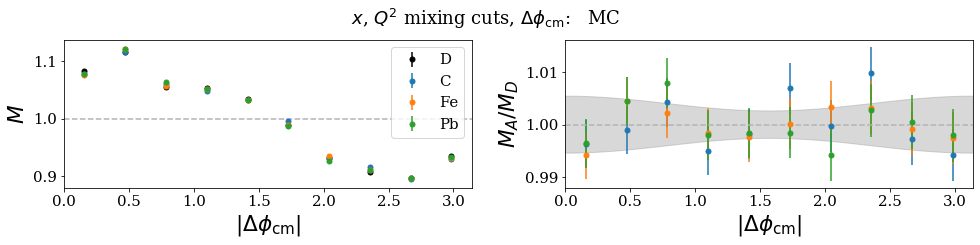

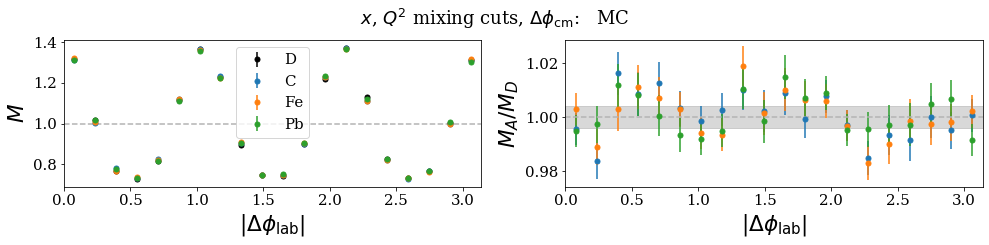

In [81]:
#mix_summary_plots(prefix='MC_',suffix='_2pi', **cm, suptitle='$x$, $\\Delta\\Phi_q$ mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$:   MC')

c0mc,c2mc = mix_summary_plots(prefix='xQ2_MC_',suffix='_2pi', **cm, suptitle='$x$, $Q^2$ mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$:   MC')
plt.savefig("../images/mixtest_xQ2_mc_combined_cm.png",bbox_inches='tight')
mix_summary_plots(prefix='xQ2_MC_',suffix='_2pi', **lab,
                  suptitle='$x$, $Q^2$ mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$:   MC', fitParams=(c0mc,0))
plt.savefig("../images/mixtest_xQ2_mc_combined_lab.png",bbox_inches='tight')



#mix_summary_plots(prefix='no_ecuts_MC_',suffix='_2pi', **cm, suptitle='no mixing cuts, $\\Delta\\phi_{\\mathrm{cm}}$:   MC')

